In [ ]:
import numpy as np
import cupy as cp
from sklearn.model_selection import train_test_split
cp.random.seed(0)
import pickle

In [ ]:
import os
import cv2 
from skimage.transform import resize #to resize img

## Download The Data

In [ ]:
!wget http://download.tensorflow.org/example_images/flower_photos.tgz

--2020-12-03 04:49:22--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  88.6MB/s    in 2.5s    

2020-12-03 04:49:25 (88.6 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
! tar -xvzf flower_photos.tgz

In [ ]:
def load_data():
  pd="/content/drive/My Drive/PMDL/A2/flower_photos"
  dirs=sorted(os.listdir(pd))
  flowers_train=[]
  classes_train=[]
  flowers_test=[]
  classes_test=[]
  c=1
  for f in dirs:
    dir=os.path.join(pd,f)
    if os.path.isdir(dir):
      fs=sorted(os.listdir(dir))
      cls=[]
      cl=len(fs)
      for j,k in enumerate(fs):
        #read img, then resize to 32 by 32 (I tried multiple sizes and this yeilded best accuracy)
        img=(cv2.imread(os.path.join(dir,k)))
        img = resize(img, (32, 32,3))
        if cl-(j+1)>=100: 
          flowers_train.append(np.array(img)) 
          classes_train.append(c)
        else:#keep last 100 of each class for test
          flowers_test.append(np.array(img)) 
          classes_test.append(c)
      c+=1
  flowers_train=np.array(flowers_train)
  classes_train=np.array(classes_train)
  flowers_test=np.array(flowers_test)
  classes_test=np.array(classes_test)
  #flatten the train and test data then return
  return (flowers_train.reshape(flowers_train.shape[0],-1),classes_train,flowers_test.reshape(flowers_test.shape[0],-1),classes_test)
    

In [ ]:
X_train,y_train,X_test,y_test=load_data()

In [ ]:
from sklearn.utils import shuffle
X_train,y_train=shuffle(X_train,y_train)

In [ ]:
X_test-=np.mean(X_test,0)
X_test/=np.std(X_test)

## Load Data

In [ ]:
%cd /content/drive/My Drive/PMDL/A3


/content/drive/My Drive/PMDL/A2


In [ ]:
#32 32 dataset

Xt=np.load('/content/drive/My Drive/PMDL/A1/Part1/X_train.npy')
Yt=np.load('/content/drive/My Drive/PMDL/A1/Part1/y_train.npy')
X_test=np.load('/content/drive/My Drive/PMDL/A1/Part1/X_test.npy')
y_test=np.load('/content/drive/My Drive/PMDL/A1/Part1/y_test.npy')

In [ ]:
Xt=cp.array(Xt)
Yt=cp.array(Yt)
X_test=cp.array(X_test)
y_test=cp.array(y_test)

In [ ]:
Xt-=cp.mean(Xt,axis=0)
Xt/=cp.std(Xt)

In [ ]:
# normalize data
X_test-=cp.mean(X_test,axis=0)
X_test/=cp.std(X_test)

In [ ]:
Xt=Xt.reshape(-1,32,32,3)
X_test=X_test.reshape(-1,32,32,3)

In [ ]:
X_test.shape

(500, 32, 32, 3)

## Classes Implementaiton

### Activation Class

In [ ]:
class Activation():

  def __init__(self,fn='relu'):
    self.fn=fn
  
  def forward(self,L):
    if self.fn=='relu':
      return cp.maximum(0,L)
    elif self.fn=='linear':
      return L
    elif self.fn=='tanh':
      return cp.tanh(L)
    elif self.fn=='sigmoid':
      return 1/(1+cp.exp(-L))

    elif self.fn=='softmax': # for output layer
      m=cp.max(L,axis=-1).reshape(-1,1)
      L=L-m
      return cp.exp(L)/cp.sum(cp.exp(L),axis=1,keepdims=True)
  
  def backward(self,L):
    if self.fn=='relu': # relu grad
      grad=cp.ones((L.shape))
      grad[L<0]=0
      return grad

    elif self.fn=='tanh' : #tanh derivative
      return 1-cp.tanh(L)**2
      
    elif self.fn=='linear' : #tanh derivative
      return L
  def backward_output(self,yt,yp): # derivative of the last layer
  # NLL derivative
    grad=(yp-yt)/cp.sum((yp),axis=1).reshape(-1,1)
    return grad


### Input Layer

In [ ]:
class Input(): # input layer
  def __init__(self,input_shape):
    self.input_shape=input_shape
    self.output_shape=input_shape

### Dense Layer

In [ ]:
class Dense():
  
  def __init__(self, n_nodes,activ_fn='relu'):
    self.n_nodes=n_nodes
    self.activation=Activation(activ_fn)
    self.activ_fn=activ_fn


  def initialization(self,A_prev_dim):
    input_shape=A_prev_dim
    # wts init.

    self.Ws= cp.random.normal(0,cp.sqrt(2 / input_shape[0]),size=(*input_shape, self.n_nodes))   #xavier initializaation
    self.b = cp.zeros((self.n_nodes,1))


    # for adam optim
    self.v_ws=cp.zeros(self.Ws.shape)
    self.acc_ws=cp.zeros(self.Ws.shape)
    self.v_b=cp.zeros(self.b.shape)
    self.acc_b=cp.zeros(self.b.shape)

    self.b1=0.99
    self.b2=0.999
    
    self.output_shape=(self.n_nodes,)
 
    
  def forward_prop(self,A_prev,for_prediction=False):
    m=A_prev.shape[0] # num of examples
    #linear Activation
    L=cp.dot(self.Ws.T,A_prev.T)+self.b
    L=L.T

    self.m=m
    self.A_prev=A_prev
    self.L=L
    self.A=self.activation.forward(L) # apply activation

    return self.A

  def backward_prop(self,dA_prev):

    if self.activ_fn !='softmax': # not output layer
      dL=self.activation.backward(self.L)*dA_prev # linear grad
    else:
      dL=dA_prev
    
    dW=1/self.m*cp.dot(self.A_prev.T,dL) # grad of W
    db=1/self.m*cp.sum(dL, axis=0,keepdims=True) 
    db=db.T

    dA_prev=cp.dot(dL,self.Ws.T) # output Grad

    self.dWs,self.db=dW,db
    return dW,db,dA_prev
  

  def update_wts(self,lr,t=0,adam=True): # default to Adam
    
    if not adam:
      self.Ws-=lr*self.dWs
      self.db-=lr*self.db
      return
    
    #bias correction
    eps=1e-7
    bias_correction1=1-self.b1**t
    
    bias_correction2=1-self.b2**t

    #Adam update for Ws

    self.v_ws=self.v_ws*(self.b1)+(1-self.b1)*self.dWs
    self.acc_ws=self.acc_ws*self.b2+(1-self.b2)*(self.dWs**2)

    # self.v_ws/=(bias_correction1)
    # self.acc_ws/= (bias_correction2)

    self.Ws=self.Ws-lr*self.v_ws/(cp.sqrt(self.acc_ws)+eps)

    #Adam update for b

    self.v_b=self.v_b*(self.b1)+(1-self.b1)*self.db
    self.acc_b=self.acc_b*self.b2+(1-self.b2)*(self.db**2)

    # self.v_b/=(bias_correction1)
    # self.acc_b/= (bias_correction2)

    self.b=self.b-lr*self.v_b/(cp.sqrt(self.acc_b)+eps)

  
  


### Dropout Layer Calss

In [ ]:
class Dropout_Layer(object):
  def __init__(self,rate):
    self.rate=rate # dropout rate
  
  def initialization(self,input_shape):
    self.input_shape=input_shape
    self.output_shape=input_shape # same output
  
  def forward_prop(self,Aprev,for_prediction=False):
    #drop_mask=cp.random.rand(*self.input_shape)
    if for_prediction: # for predictiob -> no dropout
      return Aprev
    drop_mask= cp.random.binomial(1, self.rate, size=Aprev.shape) / self.rate #drop_mask>= self.rate
    self.drop_mask=drop_mask
    A_out=Aprev*self.drop_mask
    #A_out=A_out/(self.rate)
    return A_out
  
  def backward_prop(self,dA_prev):

    dA_out=dA_prev*self.drop_mask
    #dA_out=dA_out/(self.rate)
    return None,None,dA_out
  
  def update_wts(self,lr,t=0,adam=True):
    pass



### Flatten Layer Class

In [ ]:
class Flattening_Layer():

  def __init__(self):
    pass
  
  def initialization(self,A_shape):
    self.input_shape=A_shape # input shae

    print(A_shape)
    out=1
    for s in A_shape:
      out*=s  # output share = mult of all elements of the input shape

    self.output_shape=(out,)

  
  def forward_prop(self,A,for_prediction=False):
    self.m=A.shape[0]

    return A.reshape(self.m,-1) # reshape out
  
  def backward_prop(self,dA):
    return None,None,dA.reshape(self.m,*self.input_shape) # reshape
  
  def update_wts(self,lr,t=0,adam=True): # no implementation
    pass




### MaxPooling Layer Calss

In [ ]:
class MaxPooling():

  def __init__(self,filter_size,stride):
    self.filter_size=filter_size
    self.stride=stride
  

  def initialization(self,A_prev_shape):

    # initiaization of shapes 
    self.H_prev,self.W_prev,self.n_filters_prev=A_prev_shape[0],A_prev_shape[1],A_prev_shape[2]
    self.H_out=int((self.H_prev-self.filter_size)/self.stride)+1 # apply equaiton
    self.W_out=int((self.W_prev-self.filter_size)/self.stride)+1
    self.n_filters_out=self.n_filters_prev # same output filter sizes

    self.output_shape=( self.H_out,self.W_out,self.n_filters_out) # output shape for sequential model purposes
    print(self.output_shape)

  def forward_prop(self,Aprev,for_prediction=False):
    # a prev shape (m,H,W,n_filters)
    self.Aprev=Aprev

    m=Aprev.shape[0] # num of examples

    A_out=cp.ones((m,self.H_out,self.W_out,self.n_filters_out)) # output activation map
    
    for i in range(self.H_out): #loop over the shape of the output
      s1=i*self.stride #slide start
      e1=self.filter_size+s1 # slice end

      for j in range(self.W_out):
        s2=j*self.stride # slice start
        e2=self.filter_size+s2 # slice end

        A_out[:,i,j,:]=cp.max(Aprev[:,s1:e1,s2:e2,:],axis=(1,2)) # get the maximum of every slice 
    self.A_out=A_out
    self.m=m
    return self.A_out


  def backward_prop(self,dA):
    # prev gradient shape (m,H,W,C)

    dA_out=cp.ones((self.m,self.H_prev,self.W_prev,self.n_filters_prev))

    for i in range(self.H_out): # loop over the shape of the input grad
      s1=i*self.stride #slide start
      e1=self.filter_size+s1 # slice end

      for j in range(self.W_out):
        s2=j*self.stride # slice start
        e2=self.filter_size+s2 # slice end

        # get deriative by getting the max element and zero the other of each slice
        values=self.Aprev[:,s1:e1,s2:e2,:]
        grads=cp.ones(values.shape)

        values=values.reshape(values.shape[0],-1,values.shape[-1]) # reshape to take argmax
        org_vlaue_shape=values.shape
        values=cp.argmax(values,axis=1) # argmax the value to get the max indics
        orginial_shape=grads.shape
        grads=grads.reshape(org_vlaue_shape)
        #print('grad', orginial_shape, 'val', values.shape)

        # places coreepponding to the maxiumm have grad =1
        i1,i2=cp.indices((orginial_shape[0],orginial_shape[3]))
        grads[i1,values,i2]=1
        grads=grads.reshape(orginial_shape)

        # accumulate gradient by multiply by gradient
        dA_out[:,s1:e1,s2:e2,:]=dA[:,i:i+1,j:j+1,:]*grads
    
    return None,None,dA_out
  
  def update_wts(self,lr,t=0,adam=True):
    return



### Conv2D Layer Class

In [ ]:
class Conv2D():

  def __init__(self, n_filters,filter_size,stride,padding=None,activ_fn='relu'):
    self.n_filters=n_filters
    self.filter_size=filter_size
    self.stride=stride
    self.padding=padding
    self.activation=Activation(activ_fn) # activation function 

  
  def initialization(self, input_shape):
     # A_prev size= (m,Hprev,Wprev,n_filtersprev)
    self.H_prev,self.W_prev,self.n_filters_prev=input_shape[0],input_shape[1],input_shape[2]

    if self.padding=='same':
       # padding equation adapted for stride size
        p=int((self.filter_size+(self.H_prev)*self.stride-self.H_prev-1)/2)
        
    else:
      p=0
    
    #output activation map shape
    self.H_out=int((self.H_prev+2*p-self.filter_size)/self.stride)+1
    self.W_out=int((self.W_prev-self.filter_size+2*p)/self.stride)+1


   
    
    #Wts init.
    nout=(self.filter_size*self.filter_size*self.n_filters) # Xavier for Conv Layers
    self.Ws=cp.random.normal(0,cp.sqrt(2/nout),size=(self.filter_size,self.filter_size,self.n_filters_prev,self.n_filters))
    self.b=cp.zeros((1,1,1,self.n_filters))

    # for adam optim
    self.v_ws=cp.zeros(self.Ws.shape)
    self.acc_ws=cp.zeros(self.Ws.shape)
    self.v_b=cp.zeros(self.b.shape)
    self.acc_b=cp.zeros(self.b.shape)

    self.b1=0.9
    self.b2=0.999
    
    # for sequential model
    self.output_shape=(self.H_out,self.W_out,self.n_filters)
    self.p=p

    print("conv 2d ", self.output_shape)
  
  def forward_prop(self, Aprev,for_prediction=False):
    

    if self.padding=='same':
      p=self.p
      Aprev=cp.pad(Aprev, ((0, 0), (p, p), (p, p), (0, 0)), mode='constant') # padd with zeros

    self.Aprev=Aprev

    m=Aprev.shape[0] # num of examples
    self.m=m

    A_out=cp.ones((m,self.H_out,self.W_out,self.n_filters)) # output activation map


    # loop over the output activation map
    for i in range(self.H_out):
      s1=i*self.stride #slide start
      e1=self.filter_size+s1 # slice end

      for j in range(self.W_out):
        s2=j*self.stride # slice start
        e2=self.filter_size+s2 # slice end

        map_slice=Aprev[:,s1:e1,s2:e2,:]
        
        # BroadCast , convole and sum on the the number width, height, depth of input the activation slice
        A_out[:,i,j,:]=cp.sum(map_slice[:,:,:,:,cp.newaxis]*self.Ws[cp.newaxis,:,:,:,:],axis=(1,2,3))
    
    self.L=A_out+self.b
    self.A=self.activation.forward(self.L) # apply activation


    return self.A

  def backward_prop(self,dA):

    # dA dim (m,H_prev,W_prev,C_prev)
    dA_out=cp.zeros(self.Aprev.shape) # same dim as Aprev

    # if there is padding
    Aprev=self.Aprev
    if self.padding=='same':
      p=int((self.filter_size-1)/2)
      p=self.p
      #dA_out=cp.pad(dA_out, ((0, 0), (p, p), (p, p), (0, 0)), mode='constant')
      #Aprev=cp.pad(Aprev, ((0, 0), (p, p), (p, p), (0, 0)), mode='constant') # padd with zeros
    else:
      p=0

    dL=self.activation.backward(self.L)*dA # linear grad- similar to Dense
    db=1/self.m*cp.sum(dL,keepdims=True,axis=(0,1,2))
    dWs=cp.zeros(self.Ws.shape)

    # loop over the slices of dA
    for i in range(self.H_out):
      s1=i*self.stride #slide start
      e1=self.filter_size+s1 # slice end

      for j in range(self.W_out):
        s2=j*self.stride # slice start
        e2=self.filter_size+s2 # slice 
        #print(dWs.flatten()[0])
        #Broadcast convole and sum on the num of exampls to add to dW
        dWs=dWs+cp.sum(dL[:,i:i+1,j:j+1,cp.newaxis,:]*Aprev[:,s1:e1,s2:e2,:,cp.newaxis],axis=0)

        # Broadcast convole and sum on the n_filters of the preceding layer to add to grad out

        dA_out[:,s1:e1,s2:e2,:]+=cp.sum(dL[:,i:i+1,j:j+1,cp.newaxis,:]*self.Ws[cp.newaxis,:,:,:,:],axis=4) 

    
    # if padding was same, remove the padded zeros before returning the gradiens
    if p>0:
      dWs=dWs/self.m # divide by num of examples
      self.dWs=dWs
      self.db=db
      dA_out=dA_out[:,p:-p,p:-p,:]

      return dWs,db,dA_out

    else:
      dWs=dWs/self.m # divide by num of examples
      self.dWs=dWs
      self.db=db
      return dWs,db,dA_out
    

  def update_wts(self,lr,t=0,adam=True):
    if not adam:
      self.Ws-=lr*self.dWs
      self.db-=lr*self.db
      return
    
    eps=1e-7
    bias_correction1=1-self.b1**t
    
    bias_correction2=1-self.b2**t

    #Adam update for Ws

    self.v_ws=self.v_ws*(self.b1)+(1-self.b1)*self.dWs
    self.acc_ws=self.acc_ws*self.b2+(1-self.b2)*(self.dWs**2)

    # self.v_ws/=(bias_correction1)
    # self.acc_ws/= (bias_correction2)

    self.Ws=self.Ws-lr*self.v_ws/(cp.sqrt(self.acc_ws)+eps)

    #Adam update for b

    self.v_b=self.v_b*(self.b1)+(1-self.b1)*self.db
    self.acc_b=self.acc_b*self.b2+(1-self.b2)*(self.db**2)

    # self.v_b/=(bias_correction1)
    # self.acc_b/= (bias_correction2)

    self.b=self.b-lr*self.v_b/(cp.sqrt(self.acc_b)+eps)




### Sequential Model Class 

In [ ]:
class Model(): # make a sequential model

  def __init__(self):
    pass
  
  def Sequential(self,list_of_layers):
    self.list_of_layers=list_of_layers # list of layer objects
    prev_layer=list_of_layers[0]

    #initialize all layers
    for ly in self.list_of_layers[1:]:
      ly.initialization(prev_layer.output_shape) # initalize each layer
      prev_layer=ly
    
  
  def forward_all(self,X,for_prediction=False): # forward prop if each layer excpt the Input
    A_prev=X
    for ly in self.list_of_layers[1:]:
      A_prev=ly.forward_prop(A_prev,for_prediction)
    
    return A_prev
  


  def output_grad(self,yt,yp): # NLL derivative
    grad=(yp-yt)/cp.sum((yp),axis=1).reshape(-1,1)
    return grad  

  def loss(self,y_pred,y_true): # loss function 
    id=np.eye(y_pred.shape[1])[cp.asnumpy(y_true).astype(np.int32)-1].astype(np.bool)
      # take - log of the correct class probability
    sms=cp.sum(y_pred,axis=1).reshape(-1,1)
    sm=y_pred[id].reshape(-1,1)/sms
    ls=1/y_true.shape[0]*cp.sum(-cp.log(sm)) # the y is already a softmax form, take - log
    
    return ls
  
  def backward_all(self,yp,yt): # backward all layers except the first one

    dAprev=self.output_grad(yt,yp)

    
    for ly in reversed(self.list_of_layers[1:]):
      #print(f' type {type(ly)}dA {dAprev.flatten()[1:2]}')
      dWs,db,dAprev=ly.backward_prop(dAprev)
    
    #print(f' type {type(ly)}dA {dAprev.flatten()[1:2]}')
    #print("--------------------")
    return dAprev
  
  def update_wts_all(self,lr,t,adam): # update all teh wts of the layers

    for ly in self.list_of_layers[1:]:
      ly.update_wts(lr,t,adam)
  
  def train_val_split(self,Xt,Yt,ratio): #split train and validation
    X_train,X_val,y_train,y_val=train_test_split(Xt,Yt,test_size=ratio)
    return ( X_train,X_val,y_train,y_val)


  def Train(self,Xt,Yt,n_epochs,lr,train_val_ratio=0.1,batch_size=-1,verbose=True,adam=True,validation_data=None): # train the  on X,Y
    
    n_classes=len(cp.unique(Yt))
    lss_tr,ls_val=[],[]
    ac_tr,ac_val=[],[]

    if validation_data:
      X_train=Xt
      y_train=Yt
      X_val,y_val=validation_data
    else:
      X_train,X_val,y_train,y_val=self.train_val_split(Xt,Yt,train_val_ratio) # split train, val
    
    yt=cp.eye(n_classes)[cp.asnumpy(y_train).astype(cp.int32)-1]
    yv=cp.eye(n_classes)[cp.asnumpy(y_val).astype(cp.int32)-1]

    m=Yt.shape[0] #num examples
    self.lr=lr
    ts=y_train.shape[0]

    #p=self.Predict(X_val)
    #prev_val_acc=self.compute_acc(p,y_val)
    s=0
    for i in range(n_epochs+1):
      
      if batch_size!=-1: # check if there is minibatches
        n_batches=ts//batch_size
        for j in range(n_batches-1): # run minibatch GD
            s+=1

            y_pred=self.forward_all(X_train[j*batch_size:(j+1)*batch_size])
            dA=self.backward_all(y_pred,yt[j*batch_size:(j+1)*batch_size])
            self.update_wts_all(lr,s,adam)

      else: #feed all data
        y_pred=self.forward_all(X_train)
        dA=self.backward_all(y_pred,yt)
        self.update_wts_all(lr,s,adam)


      yp=self.Predict(X_train)
      yvp=self.Predict(X_val)

     
      #losses and accs for validation and test
      lst=self.loss(yp,y_train)
      lsv=self.loss(yvp,y_val)
      act=self.compute_acc(yp,y_train)
      acv=self.compute_acc(yvp,y_val)
      lss_tr.append(lst)
      ls_val.append(lsv)
      ac_tr.append(act)
      ac_val.append(acv)


      if verbose and i%5==0 : #print epoch info
          print("Epoch %d Train Loss is %f and Train Accuracy is %10f.. Val Loss is %f & Val Accuracy is %f.."%(i,lst,act,lsv,acv))
    return {'train_loss':lss_tr,'train_acc':ac_tr,'val_loss':ls_val,'val_acc':ac_val} #model History loss & accuracy

  def compute_acc(self,yp,yt): # get prediction accuracy
    return cp.sum(cp.argmax(yp,axis=1)+1==yt)/yt.shape[0]

  def Predict(self,X): #predict test or val
    yp=self.forward_all(X,for_prediction=True)
    return yp


  def evaluate(self,X_test,y_test): # evaluate the model on test
    yp=self.Predict(X_test)
    acc=self.compute_acc(yp,y_test)
    return acc
  
  def save_model(self,name,lr): #save model as pickle file
    check_point={}
   
    check_point['num_layers']=len(self.list_of_layers)
    check_point['lr']=lr
    check_point['layers']=(self.list_of_layers)

    with open(name+'.pickle', 'wb') as f:
      pickle.dump(check_point, f)
  
  def load_model(self,name): # load model to use to continue training or for prediction
    with open(name,'rb') as f:
      model=pickle.load(f)
    
    # load all model parameters
    self.list_of_layers=model['layers'] 
    self.lr=model['lr']
 
  def CCRn(self,yt,X_test): # correct clssification rate per class
    yhat=self.Predict(X_test)
    yp=cp.argmax(yhat,axis=1)+1
    cls,counts=np.unique(cp.asnumpy(yt),return_counts=True)
    ccrns={}
    cls_sizes={}
    for i,y in enumerate(cp.asnumpy(yt)):
      if y in cls_sizes:
        cls_sizes[y]+=1
      else:
        cls_sizes[y]=1
      if yp[i]==y:
        if y in ccrns:
          ccrns[y]+=1
        else:
          ccrns[y]=1
    for c in cls:
      ccrns[c]/=cls_sizes[c] #return accuracy by dividing over size of each class 
    return ccrns
  




## Learning Rate Search

In [ ]:
model=Model() # instantiating a model
model.Sequential([
                          Input((32,32,3)),
                          #Conv2D(16,5,1,'same'),
                          #MaxPooling(2,1),

                          Conv2D(8,3,1,activ_fn='relu',padding='same'),
                          MaxPooling(2,2),
                          Conv2D(16,3,1,activ_fn='relu',padding='same'),
                          MaxPooling(2,2),
                          #Dropout_Layer(0.3),
                  
                          Conv2D(32,3,1,'same',activ_fn='relu'),
                          MaxPooling(2,2),
              
                          #Dropout_Layer(0.3),
                  
                          Flattening_Layer(),
                          Dense(100),
                          Dropout_Layer(0.3),                 
                          
                          Dense(100),
                          Dropout_Layer(0.3),

                          Dense(5,'softmax')])


conv 2d  (32, 32, 8)
(16, 16, 8)
conv 2d  (16, 16, 16)
(8, 8, 16)
conv 2d  (8, 8, 32)
(4, 4, 32)
(4, 4, 32)


In [ ]:
high_lr=0.5
low_lr=0.00001
Lss=[]
for lr in [high_lr,low_lr]:
  H=model.Train(Xt,Yt,10,lr,verbose=True)

  print("finished lr %f"%(lr))
  Lss.append(min(H['val_loss']))

Epoch 0 Train Loss is 1.606336 and Train Accuracy is   0.248861.. Val Loss is 1.594477 & Val Accuracy is 0.277603..
Epoch 5 Train Loss is 1.746076 and Train Accuracy is   0.248861.. Val Loss is 1.701024 & Val Accuracy is 0.277603..
Epoch 10 Train Loss is 1.642117 and Train Accuracy is   0.220820.. Val Loss is 1.642732 & Val Accuracy is 0.217666..
finished lr 0.500000
Epoch 0 Train Loss is 1.641846 and Train Accuracy is   0.219068.. Val Loss is 1.645171 & Val Accuracy is 0.233438..
Epoch 5 Train Loss is 1.641844 and Train Accuracy is   0.219068.. Val Loss is 1.645170 & Val Accuracy is 0.233438..
Epoch 10 Train Loss is 1.641839 and Train Accuracy is   0.219068.. Val Loss is 1.645165 & Val Accuracy is 0.233438..
finished lr 0.000010


### run coarse search

In [ ]:
# coarse search for lr
#try 20 values
Lss={}
for i in range(20):
  lr=5*10**np.random.uniform(-1,-5) # limits of lr are 5*10^-1, 10^-4
  H=model.Train(Xt,Yt,10,lr,adam=True,verbose=False)
  print("finished lr %f, min loss %f"%(lr,min(H['val_loss'])))
  Lss[lr]=(min(H['val_loss']))

finished lr 0.004051, min loss 1.645967
finished lr 0.068655, min loss 1.610504
finished lr 0.001953, min loss 1.626345
finished lr 0.000776, min loss 1.642456
finished lr 0.032992, min loss 1.621287
finished lr 0.000074, min loss 1.642454
finished lr 0.000053, min loss 1.627257
finished lr 0.329873, min loss 1.611738
finished lr 0.001401, min loss 2.193727
finished lr 0.000067, min loss 2.120545
finished lr 0.002438, min loss 2.092755
finished lr 0.006011, min loss 1.995132
finished lr 0.235740, min loss 1.826854
finished lr 0.000065, min loss 2.529305
finished lr 0.208321, min loss 2.484456
finished lr 0.004017, min loss 3.023035
finished lr 0.264224, min loss 2.954833
finished lr 0.000127, min loss 3.122138
finished lr 0.000729, min loss 2.712675
finished lr 0.000120, min loss 2.915902


Text(0.5, 1.0, 'best loss per lr')

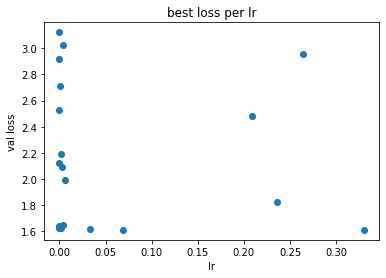

In [ ]:
ls=cp.asnumpy(list(Lss.values()))
plt.scatter(list(Lss.keys()),ls)
plt.xlabel("lr")
plt.ylabel('val loss')
plt.title("best loss per lr") # 

### run finer search**

In [ ]:
# run finer search
Lss={}
for i in range(10):
  H=model.Train(Xt,Yt,10,lr,adam=True,verbose=False)
  print("finished lr %f, min loss %f"%(lr,min(H['val_loss'])))
  Lss[lr]=(min(H['val_loss']))
  


In [ ]:
ls2=cp.asnumpy(list(Lss.values()))
plt.scatter(list(Lss.keys()),ls2) # 
plt.xlabel("lr")
plt.ylabel('val loss')
plt.title("best loss per lr") # the best is around 0.001

## Training The model

In [ ]:
model=Model()
model.Sequential([
                          Input((32,32,3)),
                          #Conv2D(16,5,1,'same'),
                          #MaxPooling(2,1),

                          Conv2D(8,3,1,activ_fn='relu',padding='same'),
                          MaxPooling(2,2),
                          Conv2D(16,3,1,activ_fn='relu',padding='same'),
                          MaxPooling(2,2),
                          #Dropout_Layer(0.3),
                  
                          Conv2D(32,3,1,'same',activ_fn='relu'),
                          MaxPooling(2,2),
              
                          #Dropout_Layer(0.3),
                  
                          Flattening_Layer(),
                          Dense(100),
                          Dropout_Layer(0.3),                 
                          
                          Dense(100),
                          Dropout_Layer(0.3),

                          Dense(5,'softmax')])


In [ ]:
# train the model
H=model.Train(Xt,Yt,320,0.001,batch_size=-1,adam=True)

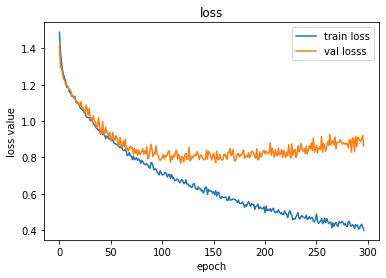

In [ ]:
import matplotlib.pyplot as plt
plt.plot(H.history['loss'][3:])
plt.plot(H.history['val_loss'][3:])
plt.legend(('train loss','val losss'))
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

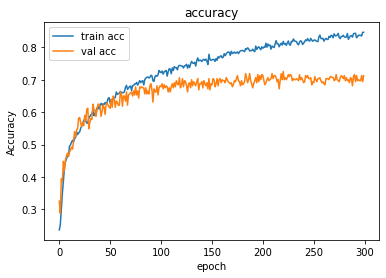

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.legend(('train acc','val acc'))
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

## CCRN




In [ ]:
#model.save_model('2nd_best',0.001)

### Best Model CCRN

In [ ]:
model=Model()
model.load_model('kk.pickle')

In [ ]:
ccrns=model.CCRn(y_test,X_test)
names=["daisy", "dandelion", "roses", "sunflowers", "tulips"]
print((ccrns))
for k in sorted(ccrns):
  print( 'accuracy for class %d (%s) is %f'%(k,names[k-1],ccrns[k]))

{4: 0.89, 2: 0.92, 1: 0.92, 5: 0.7, 3: 0.88}
accuracy for class 1 (daisy) is 0.920000
accuracy for class 2 (dandelion) is 0.920000
accuracy for class 3 (roses) is 0.880000
accuracy for class 4 (sunflowers) is 0.890000
accuracy for class 5 (tulips) is 0.700000


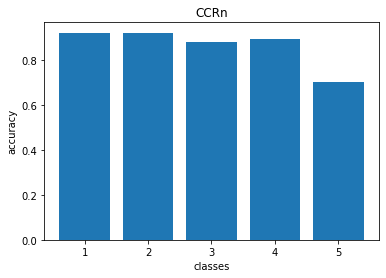

In [ ]:
#represent them in bar chart
plt.bar(ccrns.keys(),ccrns.values())
plt.xlabel("classes")
plt.ylabel("accuracy")
plt.title("CCRn")
plt.show()

### 2nd Best model CCRN

In [ ]:
model=Model()
model.load_model('2nd_best.pickle')

In [ ]:
ccrns=model.CCRn(y_test,X_test)
names=["daisy", "dandelion", "roses", "sunflowers", "tulips"]
print((ccrns))
for k in sorted(ccrns):
  print( 'accuracy for class %d (%s) is %f'%(k,names[k-1],ccrns[k]))

{1: 0.82, 2: 0.5, 3: 0.59, 4: 0.77, 5: 0.9}
accuracy for class 1 (daisy) is 0.820000
accuracy for class 2 (dandelion) is 0.500000
accuracy for class 3 (roses) is 0.590000
accuracy for class 4 (sunflowers) is 0.770000
accuracy for class 5 (tulips) is 0.900000


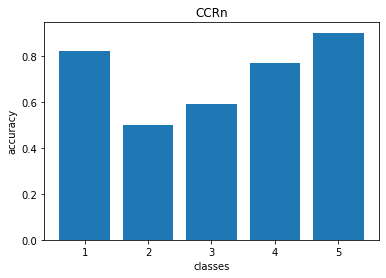

In [ ]:
#represent them in bar chart
plt.bar(ccrns.keys(),ccrns.values())
plt.xlabel("classes")
plt.ylabel("accuracy")
plt.title("CCRn")
plt.show()

## ACCR For all Calsses

### Best Model ACCR

In [ ]:
model=Model()
model.load_model('kk.pickle')


In [ ]:
BA=model.evaluate(X_test,y_test)

In [ ]:
print("Best Average Accuracy: %f "%(BA))

Best Average Accuracy: 0.862000 


### 2nd Best ACCR

In [ ]:
model2=Model()
model2.load_model('2nd_best.pickle')

In [ ]:
BA2=model2.evaluate(os_tst_x,os_tst_y)

In [ ]:
print("Best Average Accuracy: %f "%(BA2))

Best Average Accuracy: 0.716000 
